In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab_data

/content/drive/My Drive/Colab_data


In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving lanl_function.py to lanl_function (9).py


In [ ]:
pip install stellargraph

     |████████████████████████████████| 435 kB 8.7 MB/s 


In [ ]:
pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5978 sha256=f14c8581ded0b4b74963565b4b2c9a5e08ce413672a3cbb0c76bc5aa5d4d0613
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
import lanl_function as lanl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow as tf
import stellargraph as sg
from collections import Counter
from node2vec import Node2Vec
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import GraphSAGENodeGenerator
from tensorflow import keras

In [ ]:
from stellargraph.mapper import FullBatchNodeGenerator, CorruptedGenerator
from stellargraph.layer import GCN, DeepGraphInfomax

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Load Data Set: Santander Cycle

### weekly dataset

In [ ]:
# load data as pandas data frames
satander_data = {} #dictionary
satander_data[0] = pd.read_csv('satander_data/252_10Feb2021-16Feb2021.csv',header=None)
satander_data[1] = pd.read_csv('satander_data/253_17Feb2021-23Feb2021.csv',header=None)
satander_data[2] = pd.read_csv('satander_data/254_24Feb2021-02Mar2021.csv',header=None)
satander_data[3] = pd.read_csv('satander_data/255_03Mar2021-09Mar2021.csv',header=None)
satander_data[4] = pd.read_csv('satander_data/256_10Mar2021-16Mar2021.csv',header=None)
satander_data[5] = pd.read_csv('satander_data/257_17Mar2021-23Mar2021.csv',header=None)
satander_data[6] = pd.read_csv('satander_data/258_24Mar2021-30Mar2021.csv',header=None)
satander_data[7] = pd.read_csv('satander_data/259_31Mar2021-06Apr2021.csv',header=None)
satander_data[8]= pd.read_csv('satander_data/260_07Apr2021-13Apr2021.csv',header=None)
satander_data[9]= pd.read_csv('satander_data/261_14Apr2021-20Apr2021.csv',header=None)

In [ ]:
def counter_A(data,multiple = None,direct=True,min_source=0,min_des=0):
    #convert edge information into list
    edge_array= np.array(data)

    #no threshold, one adjacency matrix
    if multiple is None:
        A = Counter()
        for link in edge_array:
            if direct:
                A[link[0]-min_source,link[1]-min_des] = 1
            else:
                A[link[0]-min_source,link[1]-min_des] = 1
                A[link[1]-min_des,link[0]-min_source] = 1
        return A

    #mutiple adjacency matrix
    A_t ={}
    time_series = np.unique(edge_array[:,2])
    
    for t in time_series:
        A_t[t-np.min(time_series)] = Counter()
        
    for link in edge_array:
        if direct:
            A_t[link[2]-np.min(time_series)][link[0]-min_source,link[1]-min_des] = 1
        else:
            A_t[link[2]-np.min(time_series)][link[0]-min_source,link[1]-min_des] = 1
            A_t[link[2]-np.min(time_series)][link[1]-min_des,link[0]-min_source] = 1
    return A_t

In [ ]:
#construct counter
satander_counter = {}
for i in range(10):
    satander_counter[i] = counter_A(satander_data[i],multiple = None,direct=False,min_source=1,min_des=1)
    
#dimension (square: 845*845)
#construct adjacency matric
satander_A_mat = {}
for i in range(10):
    satander_A_mat[i] = lanl.counter2A(satander_counter[i],m=845,n=845)

#### Test for sparsity of adjacency matrix

In [ ]:
#test sparsity: larger than 10% connection
for t in range(10):
  print(np.sum(satander_A_mat[t])/714025)


0.10399775918210147
0.14884912993242533
0.1685053044361192
0.14664472532474354
0.13388746892615805
0.16365113266342216
0.17773887468926158
0.1859514722873849
0.16776863555197646
0.20075207450719512


#### Finding all negative classes

In [ ]:
#find all negative class
satander_negative_class = {}
for t in range(10):
  negative_class = np.zeros((845*845,2))
  for i in range(845):
    negative_class[845*i:845*(1+i),0] = i*np.ones(845)
    negative_class[845*i:845*(1+i),1] = np.linspace(0,844,845)
  ## convert into counter
  negative_class_counter = Counter()
  for pair in list(negative_class):
      negative_class_counter[pair[0],pair[1]] = 0
  ## Check that the sampled elements effectively correspond to the negative class
  negative_class_indices = np.array([pair not in satander_counter[t] for pair in negative_class_counter])
  satander_negative_class[t] = negative_class[negative_class_indices]


### Daily dataset

In [ ]:
#change dataset as daily 
for i in range(10):
    edge_array= np.array(satander_data[i])
    day_idx =np.trunc(edge_array[:,2]/86400).reshape(-1,1)
    satander_data2_i = np.hstack((edge_array[:,:2],day_idx))
    if i==0:
        satander_data2 = satander_data2_i
    else:
        satander_data2 = np.vstack((satander_data2,satander_data2_i))
    

satander_data2 = pd.DataFrame(satander_data2)#convert to dataframe

#new counter
satander_counter2 = counter_A(satander_data2,multiple = True,direct=False,min_source=1,min_des=1)
#new adjacency matrices
satander_A_mat2 = {}
for i in range(70):
    satander_A_mat2[i] = lanl.counter2A(satander_counter2[i],m=845,n=845)

#### Test for sparsity of adjacency matrix

In [ ]:
#test sparsity
ratio = []
for t in range(70):
  ratio.append(np.sum(satander_A_mat2[t])/714025)

print('Maximum ratio is '+str(np.max(ratio)))
print('Miniximum ratio is '+str(np.min(ratio)))

Maximum ratio is 0.06695143727460523
Miniximum ratio is 0.02195441336087672


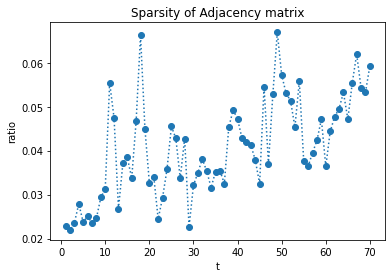

In [ ]:
plt.plot(np.linspace(1,70,70),ratio,':o')
plt.ylabel('ratio')
plt.xlabel('t')
plt.title('Sparsity of Adjacency matrix')
plt.show()

#### Finding all negative classes

In [ ]:
#find all negative class
satander_negative_class2 = {}
for t in range(70):
  negative_class = np.zeros((845*845,2))
  for i in range(845):
    negative_class[845*i:845*(1+i),0] = i*np.ones(845)
    negative_class[845*i:845*(1+i),1] = np.linspace(0,844,845)
  ## convert into counter
  negative_class_counter = Counter()
  for pair in list(negative_class):
      negative_class_counter[pair[0],pair[1]] = 0
  ## Check that the sampled elements effectively correspond to the negative class
  negative_class_indices = np.array([pair not in satander_counter2[t] for pair in negative_class_counter])
  satander_negative_class2[t] = negative_class[negative_class_indices]


# Weekly dataset

## **Unsupervised GraphSAGE**

### Procedure of embedding

In [ ]:
np.random.seed(11711)
U = {}
loss = {}
#d=10dimension of embedding

In [ ]:
#construct graphs
attr = pd.DataFrame(np.diag(np.ones(845)), index=list(range(845)))
for t in range(1,9):
    print('Graph: ' + str(t+1))
    G = sg.StellarGraph.from_networkx(nx.from_scipy_sparse_matrix(satander_A_mat[t]),node_features=attr)
    unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), length=10, number_of_walks=10)
    generator = GraphSAGELinkGenerator(G, batch_size=512, num_samples=[10, 10])
    train_gen = generator.flow(unsupervised_samples)
    graphsage = GraphSAGE(layer_sizes=[50, 10], generator=generator, bias=True, dropout=0.0, normalize="l2")
    # Build the model and expose input and output sockets of GraphSAGE, for node pair inputs:
    x_inp, x_out = graphsage.in_out_tensors()
    prediction = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss=keras.losses.binary_crossentropy, metrics=[keras.metrics.binary_accuracy])
    history = model.fit(train_gen, epochs=1, verbose=1, use_multiprocessing=False, workers=2, shuffle=True)
    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    node_ids = list(range(845))
    node_gen = GraphSAGENodeGenerator(G, batch_size=512, num_samples=[10, 10]).flow(node_ids)
    U[t], loss[t] = embedding_model.predict(node_gen, workers=2, verbose=1), history.history['loss']
    np.save('graphsage_'+str(t)+'.npy',U[t])
    files.download('graphsage_'+str(t)+'.npy')
    


Graph: 2
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 123ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 3
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 140ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 4
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 125ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 5
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 156ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 6
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 112ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 7
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 100ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 8
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 146ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graph: 9
link_classification: using 'ip' method to combine node embeddings into edge embeddings
2/2 [==============================] - 1s 123ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download saved latent position

In [ ]:
#download embedding latent positions
U1 = {}
for t in range(9):
  U1[t] = np.load('satander_data/graphsage_'+str(t)+'.npy')


### Construct Edge feature

In [ ]:
def ef_hadamard(A,U,V,negative_class):
    ## Calculate the scores for negative_class
    scores_negative_class = []
    for pair in negative_class:
        scores_negative_class += [U[int(pair[0]),:]*V[int(pair[1]),:] ]
    ## Calculate the scores for positive_class
    scores_positive_class = []
    for pair in A:
        scores_positive_class += [U[int(pair[0]),:]*V[int(pair[1]),:] ]
    #combine for x and y
    x = np.vstack((np.array(scores_negative_class),np.array(scores_positive_class)))
    y = np.hstack((np.zeros(len(scores_negative_class)),np.ones(len(scores_positive_class))))
    return x,y

#use average to construct edge feature
def ef_average(A,U,V,negative_class):

    ## Calculate the scores for negative_class
    scores_negative_class = []
    for pair in negative_class:
        scores_negative_class += [(U[int(pair[0]),:]+V[int(pair[1]),:])*0.5]
    ## Calculate the scores for positive_class
    scores_positive_class = []
    for pair in A:
        scores_positive_class += [(U[int(pair[0]),:]+V[int(pair[1]),:])*0.5]
    #combine for x and y
    x = np.vstack((np.array(scores_negative_class),np.array(scores_positive_class)))
    y = np.hstack((np.zeros(len(scores_negative_class)),np.ones(len(scores_positive_class))))
    return x,y

In [ ]:
average_U1 = lanl.average_mat(U1)

In [ ]:
#for prediction at t=9
t=9
#hadarmard
hadarmard_edgefeature,V1 = ef_hadamard(satander_counter[t],average_U1,average_U1,satander_negative_class[t])
#average
average_edgefeature,V2 = ef_average(satander_counter[t],average_U1,average_U1,satander_negative_class[t])

In [ ]:
def logit_pred(edge_feature,V,m=None,n=None):
  M = np.hstack((np.ones((len(edge_feature),1)),edge_feature))
  logit_model =  LogisticRegression(max_iter=5000)
  logit_model.fit(M,V)
  beta = logit_model.coef_
  pred_V =  np.dot(M,beta.T)
  return roc_auc_score(V,pred_V)


In [ ]:
#hadaemard
logit_pred(hadarmard_edgefeature,V1,845,845)

0.7123618938270619

In [ ]:
#average
logit_pred(average_edgefeature,V2,845,845)

0.5659827704804449

## GCN with Deep Graph Infomax

### Procedure of embedding

In [ ]:
def run_deep_graph_infomax(base_model, G, generator, epochs, lr=1e-3):
    ## Define generators
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)
    ## Infomax
    x_in, x_out = infomax.in_out_tensors()
    ## Model
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(learning_rate=lr))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
    ## Input-output
    x_emb_in, x_emb_out = base_model.in_out_tensors()
    ## For full batch models, squeeze out the batch dimension
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)
    ## Embedding model and predictions
    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
    U = emb_model.predict(generator.flow(G.nodes()))
    return U, history.history['loss']

U = {}
loss = {}
attr = pd.DataFrame(np.diag(np.ones(845)), index=list(range(845)))
for t in range(10):
    print('Graph: ' + str(t+1))
    G = sg.StellarGraph.from_networkx(nx.from_scipy_sparse_matrix(satander_A_mat[t]), node_features=attr)
    fullbatch_generator = FullBatchNodeGenerator(G)
    gcn_model = GCN(layer_sizes=[10], activations=["relu"], generator=fullbatch_generator)
    U[t], loss[t] = run_deep_graph_infomax(base_model=gcn_model, G=G, generator=fullbatch_generator, epochs=250, lr=1e-2)
    np.save('gcn_'+str(t)+'.npy',U[t])
    

### Download aved latent position

In [ ]:
#download embedding latent positions
U2 = {}
for t in range(9):
  U2[t] = np.load('satander_data/gcn_'+str(t)+'.npy')

### Construct Edge feature

In [ ]:
average_U2 = lanl.average_mat(U2)

In [ ]:
#for prediction at t=9
t=9
#hadarmard
hadarmard_edgefeature2,V1 = ef_hadamard(satander_counter[t],average_U2,average_U2,satander_negative_class[t])
#average
average_edgefeature2,V2 = ef_average(satander_counter[t],average_U2,average_U2,satander_negative_class[t])

In [ ]:
#hadaemard
logit_pred(hadarmard_edgefeature2,V1,845,845)

0.7817794456686145

In [ ]:
#average
logit_pred(average_edgefeature2,V2,845,845)

0.7202953608617526

## Spectral Embedding

In [ ]:
#AIP
X = {}
Y = {}
for t in range(9):
    X_t,Y_t = lanl.dase(satander_A_mat[t],d=10)
    X[t] = X_t
    Y[t] = Y_t

x1,y1 = lanl.aip(satander_counter[9],X,Y,satander_negative_class[9])
roc_auc_score(y1,x1)

0.8899773065888505

In [ ]:
#COSIE
hat_X,hat_Y,R = lanl.mase_direct(satander_A_mat,10)

#compute R_average
R_average = lanl.average_mat(R,0,8)

x_cosie,y_cosie = lanl.cosie_average(satander_counter[9],hat_X,hat_Y,R_average,satander_negative_class[9])
roc_auc_score(y_cosie,x_cosie)

0.8982030156562658

## Expectation

In [ ]:
#Graphsage
h_roc11 = []
a_roc11 = [ ]
for t in range(9):
  #hardarmard
  hadarmard_edgefeature,V1 = ef_hadamard(satander_counter[t],U1[t],U1[t],satander_negative_class[t])
  roc1 = logit_pred(hadarmard_edgefeature,V1,845,845)
  #average
  average_edgefeature,V2 = ef_average(satander_counter[t],U1[t],U1[t],satander_negative_class[t])
  roc2 = logit_pred(average_edgefeature,V1,845,845)
  h_roc11.append(roc1)
  a_roc11.append(roc2)

#GCN 
h_roc22 = []
a_roc22 = []
for t in range(9):
  #hardarmard
  hadarmard_edgefeature,V1 = ef_hadamard(satander_counter[t],U2[t],U2[t],satander_negative_class[t])
  roc1 = logit_pred(hadarmard_edgefeature,V1,845,845)
  #average
  average_edgefeature,V2 = ef_average(satander_counter[t],U2[t],U2[t],satander_negative_class[t])
  roc2 = logit_pred(average_edgefeature,V1,845,845)
  h_roc22.append(roc1)
  a_roc22.append(roc2)


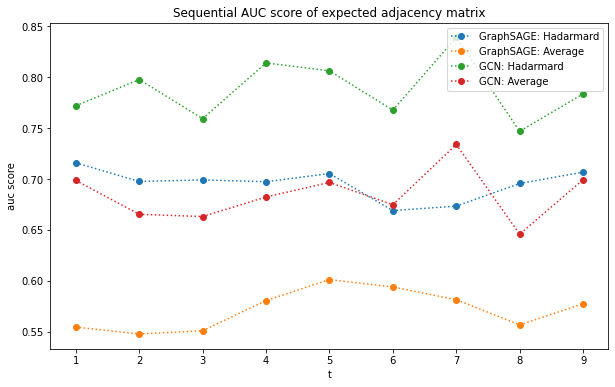

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(1,9,9),h_roc11,":o")
plt.plot(np.linspace(1,9,9),a_roc11,":o")
plt.plot(np.linspace(1,9,9),h_roc22,":o")
plt.plot(np.linspace(1,9,9),a_roc22,":o")
plt.xlabel('t')
plt.ylabel('auc score')
plt.title('Sequential AUC score of expected adjacency matrix')
plt.legend(['GraphSAGE: Hadarmard','GraphSAGE: Average','GCN: Hadarmard','GCN: Average'])
plt.show()

## Use A_t to predict for A_{t+1}

In [ ]:
#Graphsage
h_roc = []
a_roc = [ ]
for t in range(9):
  #hardarmard
  hadarmard_edgefeature,V1 = ef_hadamard(satander_counter[t+1],U1[t],U1[t],satander_negative_class[t+1])
  roc1 = logit_pred(hadarmard_edgefeature,V1,845,845)
  #average
  average_edgefeature,V2 = ef_average(satander_counter[t+1],U1[t],U1[t],satander_negative_class[t+1])
  roc2 = logit_pred(average_edgefeature,V1,845,845)
  h_roc.append(roc1)
  a_roc.append(roc2)
  

In [ ]:
#GCN 
h_roc2 = []
a_roc2 = [ ]
for t in range(9):
  #hardarmard
  hadarmard_edgefeature,V1 = ef_hadamard(satander_counter[t+1],U2[t],U2[t],satander_negative_class[t+1])
  roc1 = logit_pred(hadarmard_edgefeature,V1,845,845)
  #average
  average_edgefeature,V2 = ef_average(satander_counter[t+1],U2[t],U2[t],satander_negative_class[t+1])
  roc2 = logit_pred(average_edgefeature,V1,845,845)
  h_roc2.append(roc1)
  a_roc2.append(roc2)

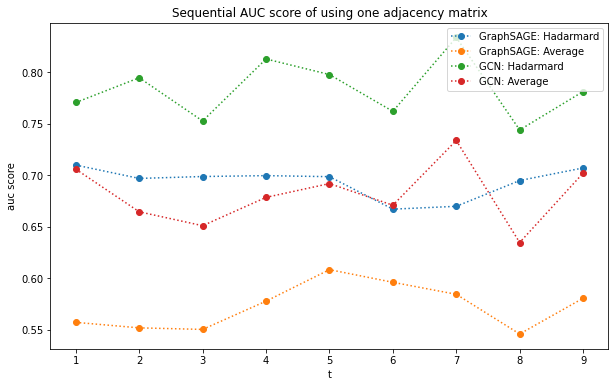

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(1,9,9),h_roc,":o")
plt.plot(np.linspace(1,9,9),a_roc,":o")
plt.plot(np.linspace(1,9,9),h_roc2,":o")
plt.plot(np.linspace(1,9,9),a_roc2,":o")
plt.xlabel('t')
plt.ylabel('auc score')
plt.title('Sequential AUC score of using one adjacency matrix')
plt.legend(['GraphSAGE: Hadarmard','GraphSAGE: Average','GCN: Hadarmard','GCN: Average'])
plt.show()

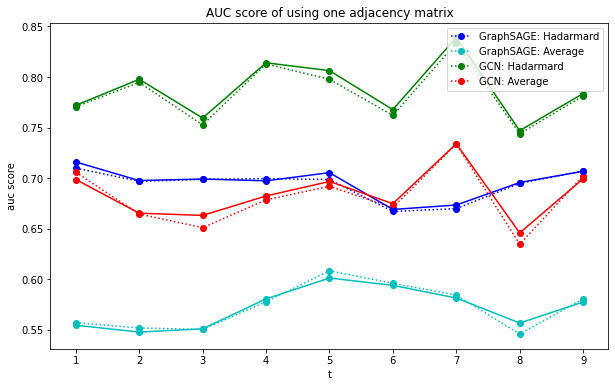

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(1,9,9),h_roc,":o",color='b')
plt.plot(np.linspace(1,9,9),a_roc,":o",color='c')
plt.plot(np.linspace(1,9,9),h_roc2,":o",color='g')
plt.plot(np.linspace(1,9,9),a_roc2,":o",color='r')
plt.plot(np.linspace(1,9,9),h_roc11,"-o",color='b')
plt.plot(np.linspace(1,9,9),a_roc11,"-o",color='c')
plt.plot(np.linspace(1,9,9),h_roc22,"-o",color='g')
plt.plot(np.linspace(1,9,9),a_roc22,"-o",color='r')
plt.xlabel('t')
plt.ylabel('auc score')
plt.title('AUC score of using one adjacency matrix')
plt.legend(['GraphSAGE: Hadarmard','GraphSAGE: Average','GCN: Hadarmard','GCN: Average'])
plt.show()

## New link predictions


In [ ]:
def unobserved_subset(A_observed,A_pred):
    #A_observed is dictionary of observed linked pairs saved in counters
    #A_pred is the link which we want to predict for
    
    time_idx = list(A_observed.keys())
    
    #all positive class
    positive_class = np.array([])
    A_keys = np.array(list(A_pred.keys()))
    
    observed_links = Counter()
    for t in time_idx:
        observed_links += A_observed[t]
        
    positive_indices = np.array([pair not in observed_links for pair in A_pred])
    positive_class = A_keys[positive_indices]
    
    #all negative class
    negative_class = np.zeros((845*845,2))
    for i in range(845):
      negative_class[845*i:845*(1+i),0] = i*np.ones(845)
      negative_class[845*i:845*(1+i),1] = np.linspace(0,844,845)
    ## convert into counter
    negative_class_counter = Counter()
    for pair in list(negative_class):
        negative_class_counter[pair[0],pair[1]] = 0
    ## Check that the sampled elements effectively correspond to the negative class
    negative_class_indices = np.array([pair not in satander_counter[t] for pair in negative_class_counter])
    negative_class = negative_class[negative_class_indices]
    
    #select 0 in A_pred
    negative_class_counter = Counter()
    for pair in list(negative_class):
        negative_class_counter[pair[0],pair[1]] = 0
    negative_class_indices = np.array([pair not in A_pred for pair in negative_class_counter])
    negative_class = negative_class[negative_class_indices]
   
    #select never observed
    negative_class_counter2 = Counter()
    for pair in list(negative_class):
        negative_class_counter2[pair[0],pair[1]] = 0
    negative_class_indices2 = np.array([pair not in observed_links for pair in negative_class_counter2])
    negative_class = negative_class[negative_class_indices2]

    
    return positive_class,negative_class

In [ ]:
A_observed = {}
for t in range(9):
  A_observed[t] = satander_counter[t]
A_pred = satander_counter[9]

In [ ]:
unob_positive,unob_negative = unobserved_subset(A_observed,A_pred)

In [ ]:
#GraphSAGE
t=9
#hadarmard
hadarmard_edgefeature,V1 = ef_hadamard(unob_positive,average_U1,average_U1,unob_negative)
print('AUC of hadarmard: '+str(logit_pred(hadarmard_edgefeature,V1)))
#average
average_edgefeature,V2 = ef_average(unob_positive,average_U1,average_U1,unob_negative)
print('AUC of average: '+str(logit_pred(average_edgefeature,V2)))

AUC of hadarmard: 0.6510882426604238
AUC of average: 0.5845602381599027


In [ ]:
#GCN
t=9
#hadarmard
hadarmard_edgefeature,V1 = ef_hadamard(unob_positive,average_U2,average_U2,unob_negative)
print('AUC of hadarmard: '+str(logit_pred(hadarmard_edgefeature,V1)))
#average
average_edgefeature,V2 = ef_average(unob_positive,average_U2,average_U2,unob_negative)
print('AUC of average: '+str(logit_pred(average_edgefeature,V2)))

AUC of hadarmard: 0.7316942491984523
AUC of average: 0.7421903442016381


In [ ]:
#AIP 
x1,y1 = lanl.aip(unob_positive,X,Y,unob_negative)
roc_auc_score(y1,x1)

0.7819699954434564

In [ ]:
#COSIE
x_cosie,y_cosie = lanl.cosie_average(unob_positive,hat_X,hat_Y,R_average,unob_negative)
roc_auc_score(y_cosie,x_cosie)

0.8109769358375847

# Daily Data


## GraphSAGE

In [ ]:
np.random.seed(11711)
U = {}
loss = {}
#d=10 dimension of embedding

In [ ]:
#construct graphs
attr = pd.DataFrame(np.diag(np.ones(845)), index=list(range(845)))
for t in range(10):
    if t%10==0:
      print('Graph: ' + str(t+1))
    G = sg.StellarGraph.from_networkx(nx.from_scipy_sparse_matrix(satander_A_mat[t]),node_features=attr)
    unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), length=10, number_of_walks=10)
    generator = GraphSAGELinkGenerator(G, batch_size=512, num_samples=[10, 10])
    train_gen = generator.flow(unsupervised_samples)
    graphsage = GraphSAGE(layer_sizes=[50, 10], generator=generator, bias=True, dropout=0.0, normalize="l2")
    # Build the model and expose input and output sockets of GraphSAGE, for node pair inputs:
    x_inp, x_out = graphsage.in_out_tensors()
    prediction = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss=keras.losses.binary_crossentropy, metrics=[keras.metrics.binary_accuracy])
    history = model.fit(train_gen, epochs=1, verbose=1, use_multiprocessing=False, workers=2, shuffle=True)
    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    node_ids = list(range(845))
    node_gen = GraphSAGENodeGenerator(G, batch_size=512, num_samples=[10, 10]).flow(node_ids)
    U[t], loss[t] = embedding_model.predict(node_gen, workers=2, verbose=1), history.history['loss']
    np.save('graphsage_day'+str(t)+'.npy',U[t])
    files.download('graphsage_day'+str(t)+'.npy')
    


### Upload saved latent positions

In [ ]:
#download embedding latent positions
U3 = {}
for t in range(7):
  U3[t] = np.load('graphsage_day'+str(t)+'.npy')

### Construct Edge feature

In [ ]:
average_U3 = lanl.average_mat(U3)

In [ ]:
#for prediction at t=6
t=6
#hadarmard
hadarmard_edgefeature3,V1 = ef_hadamard(satander_counter2[t],average_U3,average_U3,satander_negative_class2[t])
print('AUC of hadarmard: '+str(logit_pred(hadarmard_edgefeature3,V1,845,845)))
#average
average_edgefeature3,V2 = ef_average(satander_counter2[t],average_U3,average_U3,satander_negative_class2[t])
print('AUC of average: '+str(logit_pred(average_edgefeature3,V2,845,845)))

AUC of hadarmard: 0.7011212134365472
AUC of average: 0.5490225099951997


## GCN

In [ ]:
def run_deep_graph_infomax(base_model, G, generator, epochs, lr=1e-3):
    ## Define generators
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)
    ## Infomax
    x_in, x_out = infomax.in_out_tensors()
    ## Model
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(learning_rate=lr))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
    ## Input-output
    x_emb_in, x_emb_out = base_model.in_out_tensors()
    ## For full batch models, squeeze out the batch dimension
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)
    ## Embedding model and predictions
    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
    U = emb_model.predict(generator.flow(G.nodes()))
    return U, history.history['loss']

U = {}
loss = {}
attr = pd.DataFrame(np.diag(np.ones(845)), index=list(range(845)))
for t in range(7):
    print('Graph: ' + str(t+1))
    G = sg.StellarGraph.from_networkx(nx.from_scipy_sparse_matrix(satander_A_mat2[t]), node_features=attr)
    fullbatch_generator = FullBatchNodeGenerator(G)
    gcn_model = GCN(layer_sizes=[10], activations=["relu"], generator=fullbatch_generator)
    U[t], loss[t] = run_deep_graph_infomax(base_model=gcn_model, G=G, generator=fullbatch_generator, epochs=250, lr=1e-2)
    np.save('gcn_day'+str(t)+'.npy',U[t])

Graph: 1
Using GCN (local pooling) filters...
Graph: 2
Using GCN (local pooling) filters...
Graph: 3
Using GCN (local pooling) filters...
Graph: 4
Using GCN (local pooling) filters...
Graph: 5
Using GCN (local pooling) filters...
Graph: 6
Using GCN (local pooling) filters...
Graph: 7
Using GCN (local pooling) filters...


In [ ]:
for t in range(7):
  files.download('gcn_day'+str(t)+'.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Upload saved latent positon

In [ ]:
#download embedding latent positions
U4 = {}
for t in range(7):
  U4[t] = np.load('gcn_day'+str(t)+'.npy')

### Construct Edge feature

In [ ]:
average_U4 = lanl.average_mat(U4)

In [ ]:
#for prediction at t=6
t=6
#hadarmard
hadarmard_edgefeature3,V1 = ef_hadamard(satander_counter2[t],average_U4,average_U4,satander_negative_class2[t])
print('AUC of hadarmard: '+str(logit_pred(hadarmard_edgefeature3,V1,845,845)))
#average
average_edgefeature3,V2 = ef_average(satander_counter2[t],average_U4,average_U4,satander_negative_class2[t])
print('AUC of average: '+str(logit_pred(average_edgefeature3,V2,845,845)))

AUC of hadarmard: 0.7429587567122157
AUC of average: 0.6415701727435268


## Spectral embedding

In [ ]:
#AIP
X2 = {}
Y2 = {}
for t in range(9):
    X_t,Y_t = lanl.dase(satander_A_mat2[t],d=10)
    X2[t] = X_t
    Y2[t] = Y_t

x12,y12 = lanl.aip(satander_counter2[t],X2,Y2,satander_negative_class2[t])
print('AUC of AIP: '+str(roc_auc_score(y12,x12)))

AUC of AIP: 0.8776315248539432


In [ ]:
#COSIE
hat_X2,hat_Y2,R2 = lanl.mase_direct(satander_A_mat2,10)

#compute R_average
R_average2 = lanl.average_mat(R2,0,5)

x_cosie2,y_cosie2 = lanl.cosie_average(satander_counter2[t],hat_X2,hat_Y2,R_average2,satander_negative_class2[t])
print('AUC of AIP: '+str(roc_auc_score(y_cosie2,x_cosie2)))

AUC of AIP: 0.8787644318136478


## New link prediction

In [ ]:
A_observed2 = {}
for t in range(6):
  A_observed2[t] = satander_counter2[t]
A_pred2 = satander_counter2[6]

In [ ]:
unob_positive,unob_negative = unobserved_subset(A_observed2,A_pred2)

In [ ]:
#GraphSAGE
t=9
#hadarmard
hadarmard_edgefeature,V1 = ef_hadamard(unob_positive,average_U3,average_U3,unob_negative)
print('AUC of hadarmard: '+str(logit_pred(hadarmard_edgefeature,V1)))
#average
average_edgefeature,V2 = ef_average(unob_positive,average_U3,average_U3,unob_negative)
print('AUC of average: '+str(logit_pred(average_edgefeature,V2)))

AUC of hadarmard: 0.7064379145439594
AUC of average: 0.5498350371513171


In [ ]:
#GCN
t=9
#hadarmard
hadarmard_edgefeature,V1 = ef_hadamard(unob_positive,average_U4,average_U4,unob_negative)
print('AUC of hadarmard: '+str(logit_pred(hadarmard_edgefeature,V1)))
#average
average_edgefeature,V2 = ef_average(unob_positive,average_U4,average_U4,unob_negative)
print('AUC of average: '+str(logit_pred(average_edgefeature,V2)))

AUC of hadarmard: 0.716190669442431
AUC of average: 0.6251627776719751


In [ ]:
#AIP 
x1,y1 = lanl.aip(unob_positive,X2,Y2,unob_negative)
roc_auc_score(y1,x1)

0.8724847106887578

In [ ]:
#COSIE
x_cosie,y_cosie = lanl.cosie_average(unob_positive,hat_X2,hat_Y2,R_average2,unob_negative)
roc_auc_score(y_cosie,x_cosie)

0.8832195071699942